In [ ]:
# Jupyter notebook in Jupytext format

## Initialisation

In [ ]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path)
print(f"Project path set to: {os.getcwd()}")

In [ ]:
from PathLoader import PathLoader #noqa: E402

path_loader = PathLoader("data_config.env", "current_user.env")

In [ ]:
from DataLink import DataLink #noqa: E402

data_link = DataLink(path_loader, "data_codes.csv")

In [ ]:
folder_name = "ThesisResult4-FeatureSelectionBenchmark"
exp_id = "v1"

if not os.path.exists(f"{path_loader.get_data_path()}data/results/{folder_name}"):
    os.makedirs(f"{path_loader.get_data_path()}data/results/{folder_name}")

file_save_path = f"{path_loader.get_data_path()}data/results/{folder_name}/"

In [ ]:
# Load Proteomics Palbociclib dataset
loading_code = "goncalves-gdsc-2-Palbociclib-LN_IC50-sin"
proteomic_feature_data, proteomic_label_data = data_link.get_data_using_code(
    loading_code
)

print(f"Proteomic feature data shape: {proteomic_feature_data.shape}")
print(f"Proteomic label data shape: {proteomic_label_data.shape}")

In [ ]:
# Data preparation and alignment
import numpy as np #noqa: E402

# Ensure numeric only
proteomic_feature_data = proteomic_feature_data.select_dtypes(include=[np.number])

# Align indices
common_indices = sorted(
    set(proteomic_feature_data.index) & set(proteomic_label_data.index)
)
feature_data = proteomic_feature_data.loc[common_indices]
label_data = proteomic_label_data.loc[common_indices]

print(f"Final aligned dataset shape: {feature_data.shape}")
print(f"Final aligned label shape: {label_data.shape}")

## Functions

In [ ]:
from typing import Dict, List, Literal #noqa: E402
import numpy as np #noqa: E402
import pandas as pd #noqa: E402
from scipy.stats import pearsonr, spearmanr #noqa: E402
from sklearn.metrics import r2_score #noqa: E402
from sklearn.dummy import DummyRegressor #noqa: E402
from sklearn.preprocessing import StandardScaler #noqa: E402
from toolkit import FirstQuantileImputer, f_regression_select, get_model_from_string #noqa: E402
from toolkit import (
    mrmr_select_fcq, 
    mrmr_select_fcq_fast,
    mutual_information_select,
    select_random_features,
) #noqa: E402
import time #noqa: E402

In [ ]:
def random_select_wrapper(X: pd.DataFrame, y: pd.Series, k: int) -> tuple:
    """Wrapper function for random feature selection that returns dummy scores"""
    selected_features, _ = select_random_features(X, y, k)
    # Return dummy scores (all zeros) since random selection has no meaningful scores
    dummy_scores = np.zeros(len(selected_features))
    return selected_features, dummy_scores

In [ ]:
def _drop_correlated_columns(X: pd.DataFrame, threshold: float = 0.95) -> List[str]:
    """Drop highly correlated columns to reduce redundancy"""
    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = set()
    for col in sorted(upper.columns):
        if col in to_drop:
            continue
        high_corr = upper.index[upper[col] > threshold].tolist()
        to_drop.update(high_corr)
    return [c for c in X.columns if c not in to_drop]

In [ ]:
def create_feature_selection_pipeline(
    selection_method: callable, k: int, method_name: str, model_name: str
):
    """Create pipeline for feature selection methods"""

    def pipeline_function(X_train: pd.DataFrame, y_train: pd.Series, rng: int):
        # 1) Sanitize inputs and imputation
        X_train = X_train.replace([np.inf, -np.inf], np.nan)
        y_train = pd.Series(y_train).replace([np.inf, -np.inf], np.nan)
        mask = ~y_train.isna()
        X_train, y_train = X_train.loc[mask], y_train.loc[mask]

        # 2) Imputation
        imputer = FirstQuantileImputer().fit(X_train)
        Xtr = imputer.transform(X_train, return_df=True).astype(float)
        Xtr = Xtr.fillna(0.0)

        # 3) Correlation filtering (applied to both train and test)
        # Use the working function from your baseline code [1]
        corr_keep_cols = _drop_correlated_columns(Xtr, threshold=0.95)
        Xtr_filtered = Xtr[corr_keep_cols]

        # 4) Feature selection
        k_sel = min(k, Xtr_filtered.shape[1]) if Xtr_filtered.shape[1] > 0 else 0
        if k_sel == 0:
            selected_features, selector_scores = [], np.array([])
            no_features = True
        else:
            selected_features, selector_scores = selection_method(
                Xtr_filtered, y_train, k_sel
            )
            no_features = False

        # 5) Standardization and model training
        if no_features or len(selected_features) == 0:
            model = DummyRegressor(strategy="mean")
            model_type = "DummyRegressor(mean)"
            model_params = {"strategy": "mean"}
            sel_train = Xtr_filtered.iloc[:, :0]
        else:
            sel_train = Xtr_filtered[selected_features]
            scaler = StandardScaler()
            sel_train_scaled = scaler.fit_transform(sel_train)
            sel_train_scaled = pd.DataFrame(
                sel_train_scaled, index=sel_train.index, columns=selected_features
            )

            # Train model
            if model_name == "LinearRegression":
                model = get_model_from_string("LinearRegression")
            elif model_name == "KNeighborsRegressor":
                model = get_model_from_string(
                    "KNeighborsRegressor", n_neighbors=5, weights="distance", p=2
                )
            elif model_name == "SVR":
                model = get_model_from_string("SVR", kernel="linear", C=1.0)
            else:
                raise ValueError(f"Unsupported model: {model_name}")

            model.fit(sel_train_scaled, y_train)
            model_type = model_name
            model_params = (
                model.get_params(deep=False) if hasattr(model, "get_params") else {}
            )

        return {
            "imputer": imputer,
            "corr_keep_cols": corr_keep_cols,
            "selected_features": list(selected_features),
            "selector_scores": np.array(selector_scores),
            "model": model,
            "model_type": model_type,
            "model_params": model_params,
            "scaler": scaler if not no_features else None,
            "no_features": no_features,
            "rng": rng,
        }

    return pipeline_function

In [ ]:
def feature_selection_eval(
    X_test: pd.DataFrame,
    y_test: pd.Series,
    *,
    pipeline_components: Dict,
    metric_primary: Literal["r2", "pearson_r", "spearman_r"] = "r2",
) -> Dict:
    """Evaluation function for feature selection benchmarking"""

    # Unpack components following the structure from working baseline code [1]
    imputer = pipeline_components["imputer"]
    corr_keep = set(pipeline_components["corr_keep_cols"])
    selected = list(pipeline_components["selected_features"])
    selector_scores = pipeline_components["selector_scores"]
    model = pipeline_components["model"]
    model_name = pipeline_components["model_type"]
    scaler = pipeline_components.get("scaler", None)
    no_features = pipeline_components.get("no_features", False)

    # Apply identical transforms as training
    X_test = X_test.replace([np.inf, -np.inf], np.nan)
    y_test = pd.Series(y_test).replace([np.inf, -np.inf], np.nan)
    mask_y = ~y_test.isna()
    X_test, y_test = X_test.loc[mask_y], y_test.loc[mask_y]

    Xti = imputer.transform(X_test, return_df=True).astype(float).fillna(0.0)

    # Apply same correlation filtering as training [1]
    cols_after_corr = [c for c in Xti.columns if c in corr_keep]
    Xti = Xti[cols_after_corr]

    # Select features
    Xsel = Xti[selected] if len(selected) > 0 else Xti.iloc[:, :0]

    # Standardize if scaler exists (i.e., features were selected)
    if scaler is not None and len(selected) > 0:
        Xsel_scaled = scaler.transform(Xsel)
        Xsel_scaled = pd.DataFrame(Xsel_scaled, index=Xsel.index, columns=selected)
    else:
        Xsel_scaled = Xsel

    # Predict
    if no_features or Xsel.shape[1] == 0:
        y_pred = np.full_like(
            y_test.values, fill_value=float(y_test.mean()), dtype=float
        )
    else:
        y_pred = np.asarray(model.predict(Xsel_scaled), dtype=float)

    # Calculate metrics (following the exact structure from baseline_eval [1])
    mask_fin = np.isfinite(y_test.values) & np.isfinite(y_pred)
    y_t = y_test.values[mask_fin]
    y_p = y_pred[mask_fin]

    if len(y_t) < 2:
        r2 = np.nan
        pearson_r = pearson_p = np.nan
        spearman_rho = spearman_p = np.nan
    else:
        r2 = r2_score(y_t, y_p)
        pearson_r, pearson_p = pearsonr(y_t, y_p)
        spearman_rho, spearman_p = spearmanr(y_t, y_p)

    metrics = {
        "r2": float(r2) if np.isfinite(r2) else np.nan,
        "pearson_r": float(pearson_r) if np.isfinite(pearson_r) else np.nan,
        "pearson_p": float(pearson_p) if np.isfinite(pearson_p) else np.nan,
        "spearman_rho": float(spearman_rho) if np.isfinite(spearman_rho) else np.nan,
        "spearman_p": float(spearman_p) if np.isfinite(spearman_p) else np.nan,
        "n_test_samples_used": len(y_t),
    }

    # Feature importance
    if not no_features and hasattr(model, "feature_importances_") and len(selected) > 0:
        fi = (np.array(selected), model.feature_importances_)
    elif not no_features and model_name in ("LinearRegression",) and len(selected) > 0:
        coef = getattr(model, "coef_", np.zeros(len(selected)))
        fi = (np.array(selected), np.abs(coef))
    else:
        fi = (np.array(selected), np.zeros(len(selected)))

    primary = metrics.get(metric_primary, metrics["r2"])

    return {
        "feature_importance": fi,
        "feature_importance_from": "model",
        "model_performance": float(primary) if primary is not None else np.nan,
        "metrics": metrics,
        "selected_features": selected,
        "model_name": model_name,
        "selected_scores": selector_scores,
        "k": len(selected),
        "rng": pipeline_components.get("rng", None),
        "y_pred": y_p,
        "y_true_index": y_test.index[mask_fin],
    }

## Execution 

In [ ]:
# Setup experiment parameters - using only the three requested methods
feature_set_sizes = [10, 20, 40, 80, 160, 320, 640, 1280]
models = ["KNeighborsRegressor", "LinearRegression", "SVR"]

# Define the feature selection methods including random selection as negative control
feature_selection_methods = {
    "anova_filter": f_regression_select,        # Renamed as ANOVA-filter
    "mrmr": mrmr_select_fcq_fast,                    # MRMR method [2]
    "mutual_info": mutual_information_select,   # Mutual Information method [2]
    "random_select": random_select_wrapper      # Random selection as negative control
}

print(f"Benchmarking {len(feature_selection_methods)} methods across {len(feature_set_sizes)} feature sizes and {len(models)} models")
print(f"Total conditions: {len(feature_selection_methods) * len(feature_set_sizes) * len(models)}")
print("Methods: ANOVA-filter, MRMR, Mutual Information, and Random Selection (negative control)")

In [ ]:
from toolkit import Powerkit #noqa: E402
import numpy as np #noqa: E402
import time #noqa: F811, E402

# Initialize Powerkit with proteomics data
pk = Powerkit(feature_data, label_data)

# Register all conditions (method × size × model combinations)
rngs = np.random.RandomState(42).randint(0, 100000, size=1)  # 50 repeats for robustness

start_time = time.time()

for method_name, selection_method in feature_selection_methods.items():
    for k in feature_set_sizes:
        for model_name in models:
            # Create condition name using the requested naming convention
            condition = f"{method_name}_k{k}_{model_name}"
            
            # Create pipeline for this method and size
            pipeline_func = create_feature_selection_pipeline(selection_method, k, method_name, model_name)
            
            # Add condition to Powerkit following the structure from previous notebook [1]
            pk.add_condition(
                condition=condition,
                get_importance=True,
                pipeline_function=pipeline_func,
                pipeline_args={},
                eval_function=feature_selection_eval,
                eval_args={"metric_primary": "r2"}
            )

print(f"Registered {len(pk.conditions)} conditions in {time.time() - start_time:.2f} seconds")

In [ ]:
# Run all conditions using Powerkit's parallel processing [1]
print("Starting feature selection benchmark (ANOVA-filter, MRMR, Mutual Information, Random Selection)...")
print(f"Running with {len(rngs)} random seeds and -1 n_jobs for maximum parallelization")

benchmark_start = time.time()
df_benchmark = pk.run_all_conditions(rng_list=rngs, n_jobs=-1, verbose=True)
benchmark_time = time.time() - benchmark_start

print(f"Benchmark completed in {benchmark_time:.2f} seconds")
print(f"Results shape: {df_benchmark.shape}")

In [ ]:
# Extract k value and model name from condition for easier analysis
df_benchmark["k_value"] = df_benchmark["condition"].str.extract(r'k(\d+)').astype(int)
df_benchmark["method"] = df_benchmark["condition"].str.split('_').str[0]
df_benchmark["model_name"] = df_benchmark["condition"].str.split('_').str[2]

print("Condition breakdown:")
print(df_benchmark[["condition", "method", "k_value", "model_name"]].head(10))

In [ ]:
# Save initial results
df_benchmark.to_pickle(f"{file_save_path}feature_selection_benchmark_{exp_id}.pkl")
print(f"Initial results saved to: {file_save_path}feature_selection_benchmark_{exp_id}.pkl")

In [ ]:
# Quick summary of results
print("Benchmark Summary:")
print(f"Total runs: {len(df_benchmark)}")
print(f"Unique conditions: {df_benchmark['condition'].nunique()}")
print(f"Performance range (R²): {df_benchmark['model_performance'].min():.4f} to {df_benchmark['model_performance'].max():.4f}")

# Show performance by method (including random selection as negative control)
method_summary = df_benchmark.groupby("method")["model_performance"].agg(["mean", "std", "count"])
print("\nPerformance by method (ANOVA-filter, MRMR, Mutual Information, Random Selection):")
print(method_summary.round(4))

## Results and Visualisation

### Load data

In [66]:
def save_and_print(message, report_file=None, level="info"):
    """
    Print message to console and save to report file with proper formatting.
    
    Args:
        message: The message to print and save
        report_file: File object to save to (optional)
        level: Formatting level - "header", "section", "subsection", or "info"
    """
    # Print to console
    print(message)
    
    # Save to report with proper formatting
    if report_file:
        if level == "header":
            report_file.write(f"# {message}\n\n")
        elif level == "section":
            report_file.write(f"## {message}\n\n")
        elif level == "subsection":
            report_file.write(f"### {message}\n\n")
        else:  # info level
            report_file.write(f"{message}\n\n")
    
    return message

In [67]:
# Load saved feature selection benchmark (feature_selection_benchmark_v1.pkl)
import os
import pandas as pd

# Create a new report file for capturing print statements
print_report_path = f"{file_save_path}feature_selection_print_report_{exp_id}.md"
print_report_file = open(print_report_path, 'w', encoding='utf-8')

# Write header to the print report
print_report_file.write(f"# Feature Selection Print Report - {exp_id}\n\n")
print_report_file.write(f"**Generated**: {time.strftime('%Y-%m-%d %H:%M:%S')}\n\n")
print_report_file.write("This report captures all print statements from the Results section with proper formatting.\n\n")

pkl_path = f"{path_loader.get_data_path()}data/results/{folder_name}/feature_selection_benchmark_{exp_id}.pkl"
if not os.path.exists(pkl_path):
    raise FileNotFoundError(f"Pickle not found: {pkl_path}")

df_benchmark = pd.read_pickle(pkl_path)
save_and_print(f"Loaded df_benchmark with shape: {df_benchmark.shape}", print_report_file, level="section")
# Display first rows (works in notebook)
try:
    from IPython.display import display

    display(df_benchmark.head())
except Exception:
    save_and_print(df_benchmark.head().to_string(), print_report_file, level="info")

# Re-define variables that might be needed in the loaded section
feature_set_sizes = [10, 20, 40, 80, 160, 320, 640, 1280]
models = ["KNeighborsRegressor", "LinearRegression", "SVR"]
method_labels = {
    'anova_filter': 'ANOVA-Filter',
    'mrmr': 'MRMR', 
    'mutual_info': 'Mutual Information',
    'random_select': 'Random Selection'
}

Loaded df_benchmark with shape: (2160, 14)


,rng,condition,feature_importance,feature_importance_from,model_performance,metrics,selected_features,model_name,selected_scores,k,y_pred,y_true_index,k_value,method
0,15795,anova_filter_k10_KNeighborsRegressor,"([O60716;CTND1_HUMAN, P35222;CTNB1_HUMAN, Q134...",model,0.103815,"{'r2': 0.10381494465544672, 'pearson_r': 0.423...","[O60716;CTND1_HUMAN, P35222;CTNB1_HUMAN, Q1342...",k10,"[223.43343259944592, 194.44901443737032, 215.3...",10,"[3.621355735605322, 4.480627084698676, 5.61486...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",10,anova
1,15795,anova_filter_k10_LinearRegression,"([O60716;CTND1_HUMAN, P35222;CTNB1_HUMAN, Q134...",model,0.323972,"{'r2': 0.323972112571398, 'pearson_r': 0.57500...","[O60716;CTND1_HUMAN, P35222;CTNB1_HUMAN, Q1342...",k10,"[223.43343259944592, 194.44901443737032, 215.3...",10,"[4.213938101070182, 4.2426323046908285, 4.2222...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",10,anova
2,15795,anova_filter_k10_SVR,"([O60716;CTND1_HUMAN, P35222;CTNB1_HUMAN, Q134...",model,0.304092,"{'r2': 0.30409167349439437, 'pearson_r': 0.559...","[O60716;CTND1_HUMAN, P35222;CTNB1_HUMAN, Q1342...",k10,"[223.43343259944592, 194.44901443737032, 215.3...",10,"[4.207436132006373, 4.339952966739021, 4.32016...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",10,anova
3,15795,anova_filter_k20_KNeighborsRegressor,"([O60716;CTND1_HUMAN, P26006;ITA3_HUMAN, P1431...",model,0.335321,"{'r2': 0.33532095969963516, 'pearson_r': 0.596...","[O60716;CTND1_HUMAN, P26006;ITA3_HUMAN, P14317...",k20,"[223.43343259944592, 185.29426354100713, 187.4...",20,"[3.6690735172225457, 3.8071002751890766, 4.921...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",20,anova
4,15795,anova_filter_k20_LinearRegression,"([O60716;CTND1_HUMAN, P26006;ITA3_HUMAN, P1431...",model,0.346656,"{'r2': 0.34665560638468795, 'pearson_r': 0.593...","[O60716;CTND1_HUMAN, P26006;ITA3_HUMAN, P14317...",k20,"[223.43343259944592, 185.29426354100713, 187.4...",20,"[3.979353837676647, 4.275594780595496, 4.17854...","Index(['SIDM00879', 'SIDM00213', 'SIDM00542', ...",20,anova


### Performance Comparison: Feature Selection Methods

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


# Create publication-quality box plot comparing methods across all feature sizes and models
plt.figure(figsize=(10, 6), dpi=300)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Define publication-quality color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

sns.boxplot(data=df_benchmark, x='method', y='model_performance', 
            order=['anova_filter', 'mrmr', 'mutual_info', 'random_select'],
            palette=colors, width=0.6, fliersize=3)
plt.title('Feature Selection Method Performance Comparison', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Feature Selection Method', fontsize=14, fontweight='bold')
plt.ylabel('R² Score', fontsize=14, fontweight='bold')
plt.xticks(ticks=range(4), 
           labels=[method_labels[m] for m in ['anova_filter', 'mrmr', 'mutual_info', 'random_select']],
           rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.2, linestyle='--')
plt.tight_layout()
plt.savefig(f"{file_save_path}method_comparison_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Calculate mean and standard deviation for each method
method_stats = df_benchmark.groupby('method')['model_performance'].agg(['mean', 'std', 'count']).reset_index()

# Create publication-quality bar plot with error bars
plt.figure(figsize=(10, 6), dpi=300)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Define publication-quality color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

# Create bar plot with error bars
bars = plt.bar(range(len(method_stats)), method_stats['mean'], 
               yerr=method_stats['std'], capsize=8, alpha=0.8,
               color=colors, edgecolor='black', linewidth=1)

plt.title('Mean Performance of Feature Selection Methods', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Feature Selection Method', fontsize=14, fontweight='bold')
plt.ylabel('Mean R² Score ± Std. Dev.', fontsize=14, fontweight='bold')
plt.xticks(ticks=range(len(method_stats)), 
           labels=[method_labels.get(m, m) for m in method_stats['method']],
           rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on bars with improved formatting
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f} ± {method_stats.iloc[i]["std"]:.3f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.grid(axis='y', alpha=0.2, linestyle='--')
plt.tight_layout()
plt.savefig(f"{file_save_path}method_performance_bar.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Create publication-quality faceted box plots by model type
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Define publication-quality color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

g = sns.catplot(data=df_benchmark, x='method', y='model_performance', 
                col='model_name', kind='box', height=6, aspect=1.2,
                order=['anova_filter', 'mrmr', 'mutual_info', 'random_select'],
                palette=colors, width=0.6, fliersize=3)
g.set_titles("Model: {col_name}", fontsize=14, fontweight='bold')
g.set_axis_labels("Feature Selection Method", "R² Score", fontsize=12, fontweight='bold')
g.fig.suptitle('Feature Selection Performance by ML Model', y=1.02, fontsize=16, fontweight='bold')

# Customize the plot appearance
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, alpha=0.2, linestyle='--')

plt.tight_layout()
plt.savefig(f"{file_save_path}performance_by_model_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Create comprehensive statistical summary
summary_table = df_benchmark.groupby('method')['model_performance'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('std', 'std'),
    ('min', 'min'),
    ('25%', lambda x: x.quantile(0.25)),
    ('median', 'median'),
    ('75%', lambda x: x.quantile(0.75)),
    ('max', 'max')
]).round(4)

save_and_print("Performance Statistics by Feature Selection Method:", print_report_file, level="section")
save_and_print(summary_table.to_string(), print_report_file, level="info")

### Performance vs. Feature Set Size (k value)

In [ ]:
# Derive feature_set_sizes from the dataframe to handle different runs
feature_set_sizes_viz = sorted(df_benchmark['k_value'].unique())
# Re-define feature_set_sizes for consistency
feature_set_sizes = [10, 20, 40, 80, 160, 320, 640, 1280]

# Calculate mean and standard deviation for each method and k value
k_performance_stats = df_benchmark.groupby(['method', 'k_value'])['model_performance'].agg(['mean', 'std', 'count']).reset_index()

# Create publication-quality line plot with standard deviation bands
plt.figure(figsize=(10, 6), dpi=300)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Define publication-quality color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red
markers = ['o', 's', '^', 'D']  # Circle, Square, Triangle, Diamond

# Plot each method with error bands
for i, method in enumerate(k_performance_stats['method'].unique()):
    method_data = k_performance_stats[k_performance_stats['method'] == method]
    
    # Sort by k_value to ensure proper line plotting
    method_data = method_data.sort_values('k_value')
    
    # Plot the mean line
    plt.plot(method_data['k_value'], method_data['mean'], 
             marker=markers[i], linewidth=2.5, markersize=8, 
             color=colors[i], markeredgecolor='white', markeredgewidth=1,
             label=method_labels.get(method, method))
    
    # Add standard deviation bands (shaded area)
    plt.fill_between(method_data['k_value'], 
                     method_data['mean'] - method_data['std'],
                     method_data['mean'] + method_data['std'],
                     alpha=0.15, color=colors[i])

plt.title('Feature Selection Performance vs. Number of Features Selected', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Features Selected (k)', fontsize=14, fontweight='bold')
plt.ylabel('Mean R² Score ± Std. Dev.', fontsize=14, fontweight='bold')
plt.xscale('log')  # Use log scale for better visualization of wide k range
plt.xticks(feature_set_sizes_viz, feature_set_sizes_viz, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(title='Feature Selection Method', fontsize=11, framealpha=0.9)
plt.tight_layout()
plt.savefig(f"{file_save_path}performance_vs_k_value.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Create publication-quality faceted line plots by model type
plt.figure(figsize=(18, 6), dpi=300)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Calculate stats by method, k_value, and model_name
model_k_stats = df_benchmark.groupby(['method', 'k_value', 'model_name'])['model_performance'].agg(['mean', 'std']).reset_index()

# Create subplots for each model
models = ['KNeighborsRegressor', 'LinearRegression', 'SVR']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define publication-quality color palette and markers
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red
markers = ['o', 's', '^', 'D']  # Circle, Square, Triangle, Diamond

for i, model in enumerate(models):
    model_data = model_k_stats[model_k_stats['model_name'] == model]
    
    for j, method in enumerate(model_data['method'].unique()):
        method_model_data = model_data[model_data['method'] == method].sort_values('k_value')
        
        axes[i].plot(method_model_data['k_value'], method_model_data['mean'], 
                     marker=markers[j], linewidth=2.5, markersize=6,
                     color=colors[j], markeredgecolor='white', markeredgewidth=1,
                     label=method_labels.get(method, method))
        
        axes[i].fill_between(method_model_data['k_value'],
                            method_model_data['mean'] - method_model_data['std'],
                            method_model_data['mean'] + method_model_data['std'],
                            alpha=0.15, color=colors[j])
    
    axes[i].set_title(f'{model}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Number of Features Selected (k)', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Mean R² Score', fontsize=12, fontweight='bold')
    axes[i].set_xscale('log')
    axes[i].set_xticks(feature_set_sizes_viz, feature_set_sizes_viz, fontsize=10)
    axes[i].tick_params(axis='y', labelsize=10)
    axes[i].grid(True, alpha=0.2, linestyle='--')
    axes[i].legend(fontsize=10, framealpha=0.9)

plt.suptitle('Feature Selection Performance vs. k Value by ML Model', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{file_save_path}performance_vs_k_by_model.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Statistical analysis of k value effect
save_and_print("Performance Trend Analysis by k Value:", print_report_file, level="section")
for method in df_benchmark['method'].unique():
    method_data = df_benchmark[df_benchmark['method'] == method]
    
    # Calculate correlation between k_value and performance
    correlation = method_data['k_value'].corr(method_data['model_performance'])
    
    # Calculate performance change from smallest to largest k
    k_min_perf = method_data[method_data['k_value'] == 10]['model_performance'].mean()
    k_max_perf = method_data[method_data['k_value'] == 1280]['model_performance'].mean()
    performance_change = k_max_perf - k_min_perf
    
    save_and_print(f"\n{method_labels.get(method, method)}:", print_report_file, level="subsection")
    save_and_print(f"  Correlation (k vs performance): {correlation:.4f}", print_report_file, level="info")
    save_and_print(f"  Performance change (k=10 to k=1280): {performance_change:.4f}", print_report_file, level="info")
    save_and_print(f"  Optimal k range: {method_data.groupby('k_value')['model_performance'].mean().idxmax()} features", print_report_file, level="info")

### Performance vs. Feature Set Size (k value) - Excluding Specific k Values

In [ ]:
# Create visualization excluding specific k values (e.g., k=500)
k_values_to_exclude = [500]  # Add any k values you want to exclude here

# Filter dataframe to exclude specific k values
df_filtered = df_benchmark[~df_benchmark['k_value'].isin(k_values_to_exclude)]

# Derive feature_set_sizes from the filtered dataframe
feature_set_sizes_filtered = sorted(df_filtered['k_value'].unique())

# Calculate mean and standard deviation for each method and k value
k_performance_stats_filtered = df_filtered.groupby(['method', 'k_value'])['model_performance'].agg(['mean', 'std', 'count']).reset_index()

# Create publication-quality line plot with standard deviation bands (excluding specific k values)
plt.figure(figsize=(10, 6), dpi=300)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Define publication-quality color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red
markers = ['o', 's', '^', 'D']  # Circle, Square, Triangle, Diamond

# Plot each method with error bands
for i, method in enumerate(k_performance_stats_filtered['method'].unique()):
    method_data = k_performance_stats_filtered[k_performance_stats_filtered['method'] == method]
    
    # Sort by k_value to ensure proper line plotting
    method_data = method_data.sort_values('k_value')
    
    # Plot the mean line
    plt.plot(method_data['k_value'], method_data['mean'], 
             marker=markers[i], linewidth=2.5, markersize=8, 
             color=colors[i], markeredgecolor='white', markeredgewidth=1,
             label=method_labels.get(method, method))
    
    # Add standard deviation bands (shaded area)
    plt.fill_between(method_data['k_value'], 
                     method_data['mean'] - method_data['std'],
                     method_data['mean'] + method_data['std'],
                     alpha=0.15, color=colors[i])

plt.title(f'Feature Selection Performance vs. Number of Features Selected\n(Excluding k={k_values_to_exclude})', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Features Selected (k)', fontsize=14, fontweight='bold')
plt.ylabel('Mean R² Score ± Std. Dev.', fontsize=14, fontweight='bold')
plt.xscale('log')  # Use log scale for better visualization of wide k range
plt.xticks(feature_set_sizes_filtered, feature_set_sizes_filtered, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(title='Feature Selection Method', fontsize=11, framealpha=0.9)
plt.tight_layout()
plt.savefig(f"{file_save_path}performance_vs_k_value_excluding_{'_'.join(map(str, k_values_to_exclude))}.png", dpi=300, bbox_inches='tight')
plt.show()

save_and_print(f"Created visualization excluding k values: {k_values_to_exclude}", print_report_file, level="info")
save_and_print(f"Remaining k values in visualization: {feature_set_sizes_filtered}", print_report_file, level="info")

### Performance vs. Feature Set Size (k value) - Without Standard Error Bars

In [ ]:
# Create line plot without standard error bars (cleaner visualization)
plt.figure(figsize=(10, 6), dpi=300)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Define publication-quality color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red
markers = ['o', 's', '^', 'D']  # Circle, Square, Triangle, Diamond

# Plot each method without error bands
for i, method in enumerate(k_performance_stats_filtered["method"].unique()):
    method_data = k_performance_stats_filtered[k_performance_stats_filtered["method"] == method]
    
    # Sort by k_value to ensure proper line plotting
    method_data = method_data.sort_values('k_value')
    
    # Plot the mean line only (no error bands)
    plt.plot(method_data['k_value'], method_data['mean'], 
             marker=markers[i], linewidth=2.5, markersize=8, 
             color=colors[i], markeredgecolor='white', markeredgewidth=1,
             label=method_labels.get(method, method))

plt.title('Feature Selection Performance vs. Number of Features Selected', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Features Selected (k)', fontsize=14, fontweight='bold')
plt.ylabel('Mean R² Score', fontsize=14, fontweight='bold')
plt.xscale('log')  # Use log scale for better visualization of wide k range
plt.xticks(feature_set_sizes_viz, feature_set_sizes_viz, fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=9, right=170)
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(title='Feature Selection Method', fontsize=14, framealpha=0.9)
plt.tight_layout()
plt.savefig(f"{file_save_path}performance_vs_k_value_no_error_bars.png", dpi=300, bbox_inches='tight')
plt.show()

print("Created line plot without standard error bars")

## Feature Selection Analysis

### Feature Selection Frequency Analysis

In [68]:
# Analyze feature selection frequency across all methods
save_and_print("Analyzing feature selection patterns...", print_report_file, level="section")

# Extract all selected features and create frequency analysis
all_selected_features = []
for idx, row in df_benchmark.iterrows():
    selected_features = row['selected_features']
    # Handle different data types (list, numpy array, etc.)
    if hasattr(selected_features, '__iter__') and not isinstance(selected_features, (str, dict)):
        # Convert to list if it's an iterable (like numpy array)
        if hasattr(selected_features, 'tolist'):
            selected_features = selected_features.tolist()
        elif not isinstance(selected_features, list):
            selected_features = list(selected_features)
        
        if len(selected_features) > 0:
            all_selected_features.extend(selected_features)

# Calculate overall feature frequency
feature_frequency = pd.Series(all_selected_features).value_counts().sort_values(ascending=False)

save_and_print(f"Total feature selections: {len(all_selected_features)}", print_report_file, level="info")
save_and_print(f"Unique features selected: {len(feature_frequency)}", print_report_file, level="info")
save_and_print("Top 20 most frequently selected features:", print_report_file, level="subsection")
save_and_print(feature_frequency.head(20).to_string(), print_report_file, level="info")

Analyzing feature selection patterns...
Total feature selections: 291600
Unique features selected: 6661
Top 20 most frequently selected features:
Q07157;ZO1_HUMAN      1521
P15151;PVR_HUMAN      1450
Q13422;IKZF1_HUMAN    1415
Q92556;ELMO1_HUMAN    1361
Q92608;DOCK2_HUMAN    1319
P35222;CTNB1_HUMAN    1313
Q9UBI6;GBG12_HUMAN    1305
O60716;CTND1_HUMAN    1290
P26006;ITA3_HUMAN     1243
Q6WCQ1;MPRIP_HUMAN    1221
O95292;VAPB_HUMAN     1220
Q92835;SHIP1_HUMAN    1147
Q6JBY9;CPZIP_HUMAN    1133
O95159;ZFPL1_HUMAN    1072
P29992;GNA11_HUMAN    1048
O95302;FKBP9_HUMAN    1046
O94901;SUN1_HUMAN     1031
P33316;DUT_HUMAN      1013
Q8NC56;LEMD2_HUMAN    1003
P02545;LMNA_HUMAN      998


'Q07157;ZO1_HUMAN      1521\nP15151;PVR_HUMAN      1450\nQ13422;IKZF1_HUMAN    1415\nQ92556;ELMO1_HUMAN    1361\nQ92608;DOCK2_HUMAN    1319\nP35222;CTNB1_HUMAN    1313\nQ9UBI6;GBG12_HUMAN    1305\nO60716;CTND1_HUMAN    1290\nP26006;ITA3_HUMAN     1243\nQ6WCQ1;MPRIP_HUMAN    1221\nO95292;VAPB_HUMAN     1220\nQ92835;SHIP1_HUMAN    1147\nQ6JBY9;CPZIP_HUMAN    1133\nO95159;ZFPL1_HUMAN    1072\nP29992;GNA11_HUMAN    1048\nO95302;FKBP9_HUMAN    1046\nO94901;SUN1_HUMAN     1031\nP33316;DUT_HUMAN      1013\nQ8NC56;LEMD2_HUMAN    1003\nP02545;LMNA_HUMAN      998'

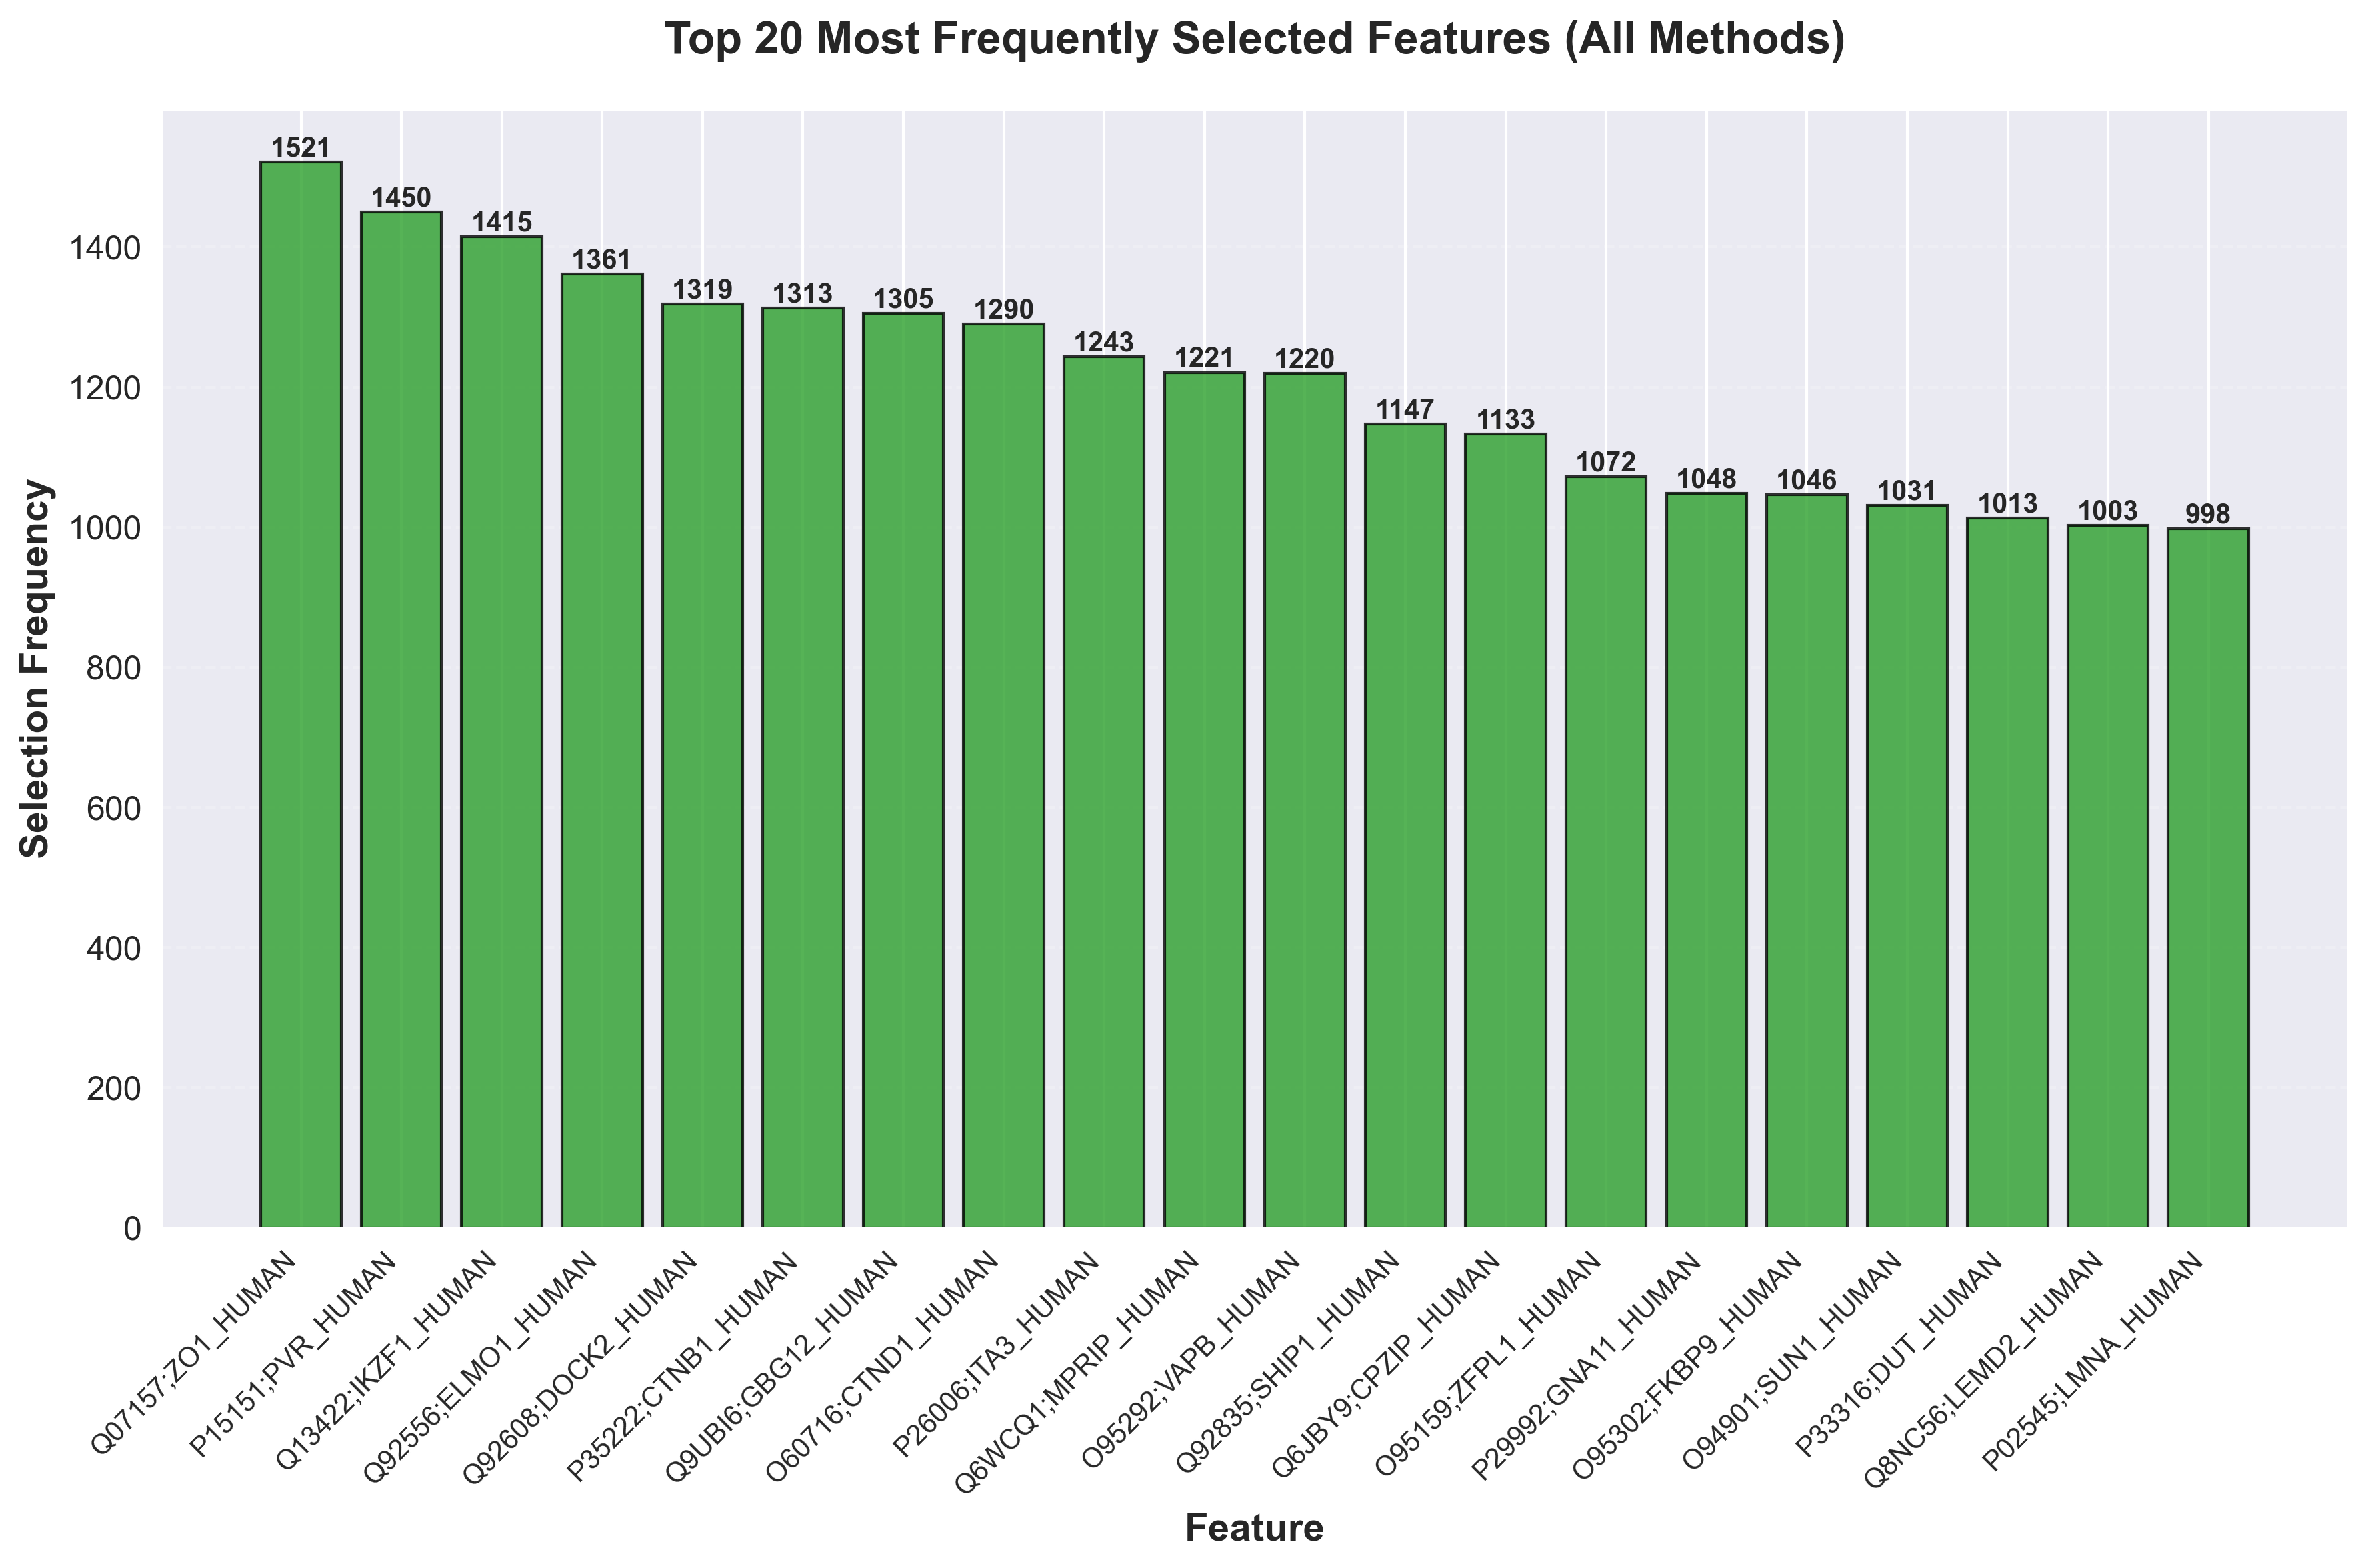

In [69]:
# Create publication-quality bar plot of top selected features
plt.figure(figsize=(12, 8), dpi=300)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.2

# Plot top 20 features
top_features = feature_frequency.head(20)
bars = plt.bar(range(len(top_features)), top_features.values, 
               color='#2ca02c', alpha=0.8, edgecolor='black', linewidth=1)

plt.title('Top 20 Most Frequently Selected Features (All Methods)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Feature', fontsize=14, fontweight='bold')
plt.ylabel('Selection Frequency', fontsize=14, fontweight='bold')
plt.xticks(range(len(top_features)), top_features.index, rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.2, linestyle='--')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{file_save_path}top_features_frequency.png", dpi=300, bbox_inches='tight')
plt.show()

In [70]:
# Analyze feature selection frequency by method
method_feature_freq = {}
for method in df_benchmark['method'].unique():
    method_features = []
    method_data = df_benchmark[df_benchmark['method'] == method]
    
    for idx, row in method_data.iterrows():
        selected_features = row['selected_features']
        # Handle different data types (list, numpy array, etc.)
        if hasattr(selected_features, '__iter__') and not isinstance(selected_features, (str, dict)):
            # Convert to list if it's an iterable (like numpy array)
            if hasattr(selected_features, 'tolist'):
                selected_features = selected_features.tolist()
            elif not isinstance(selected_features, list):
                selected_features = list(selected_features)
            
            if len(selected_features) > 0:
                method_features.extend(selected_features)
    
    method_feature_freq[method] = pd.Series(method_features).value_counts().sort_values(ascending=False)

# Display top features for each method
save_and_print("Top 10 features by method:", print_report_file, level="section")
for method, freq in method_feature_freq.items():
    save_and_print(f"\n{method_labels.get(method, method)}:", print_report_file, level="subsection")
    save_and_print(freq.head(10).to_string(), print_report_file, level="info")

Top 10 features by method:

anova:
Q13422;IKZF1_HUMAN    540
O95292;VAPB_HUMAN     540
O60716;CTND1_HUMAN    540
Q9UBI6;GBG12_HUMAN    540
Q92556;ELMO1_HUMAN    540
P15151;PVR_HUMAN      537
Q92608;DOCK2_HUMAN    537
Q07157;ZO1_HUMAN      525
O95302;FKBP9_HUMAN    513
Q6JBY9;CPZIP_HUMAN    507

MRMR:
O95292;VAPB_HUMAN     540
Q6WCQ1;MPRIP_HUMAN    501
Q07157;ZO1_HUMAN      495
P15151;PVR_HUMAN      489
Q92556;ELMO1_HUMAN    486
Q92608;DOCK2_HUMAN    483
P42771;CDN2A_HUMAN    477
Q13422;IKZF1_HUMAN    471
Q9UBI6;GBG12_HUMAN    468
O60716;CTND1_HUMAN    468

mutual:
P33316;DUT_HUMAN      531
P07339;CATD_HUMAN     528
O95159;ZFPL1_HUMAN    519
P57105;SYJ2B_HUMAN    513
P35222;CTNB1_HUMAN    511
P47914;RL29_HUMAN     499
Q07157;ZO1_HUMAN      488
P29992;GNA11_HUMAN    479
P00387;NB5R3_HUMAN    468
Q9H773;DCTP1_HUMAN    463

random:
Q9Y5Y6;ST14_HUMAN     25
O00488;ZN593_HUMAN    24
Q9BVM4;GGACT_HUMAN    23
Q8N8A2;ANR44_HUMAN    23
Q9NXC5;MIO_HUMAN      23
P19320;VCAM1_HUMAN    23
P49918;CDN

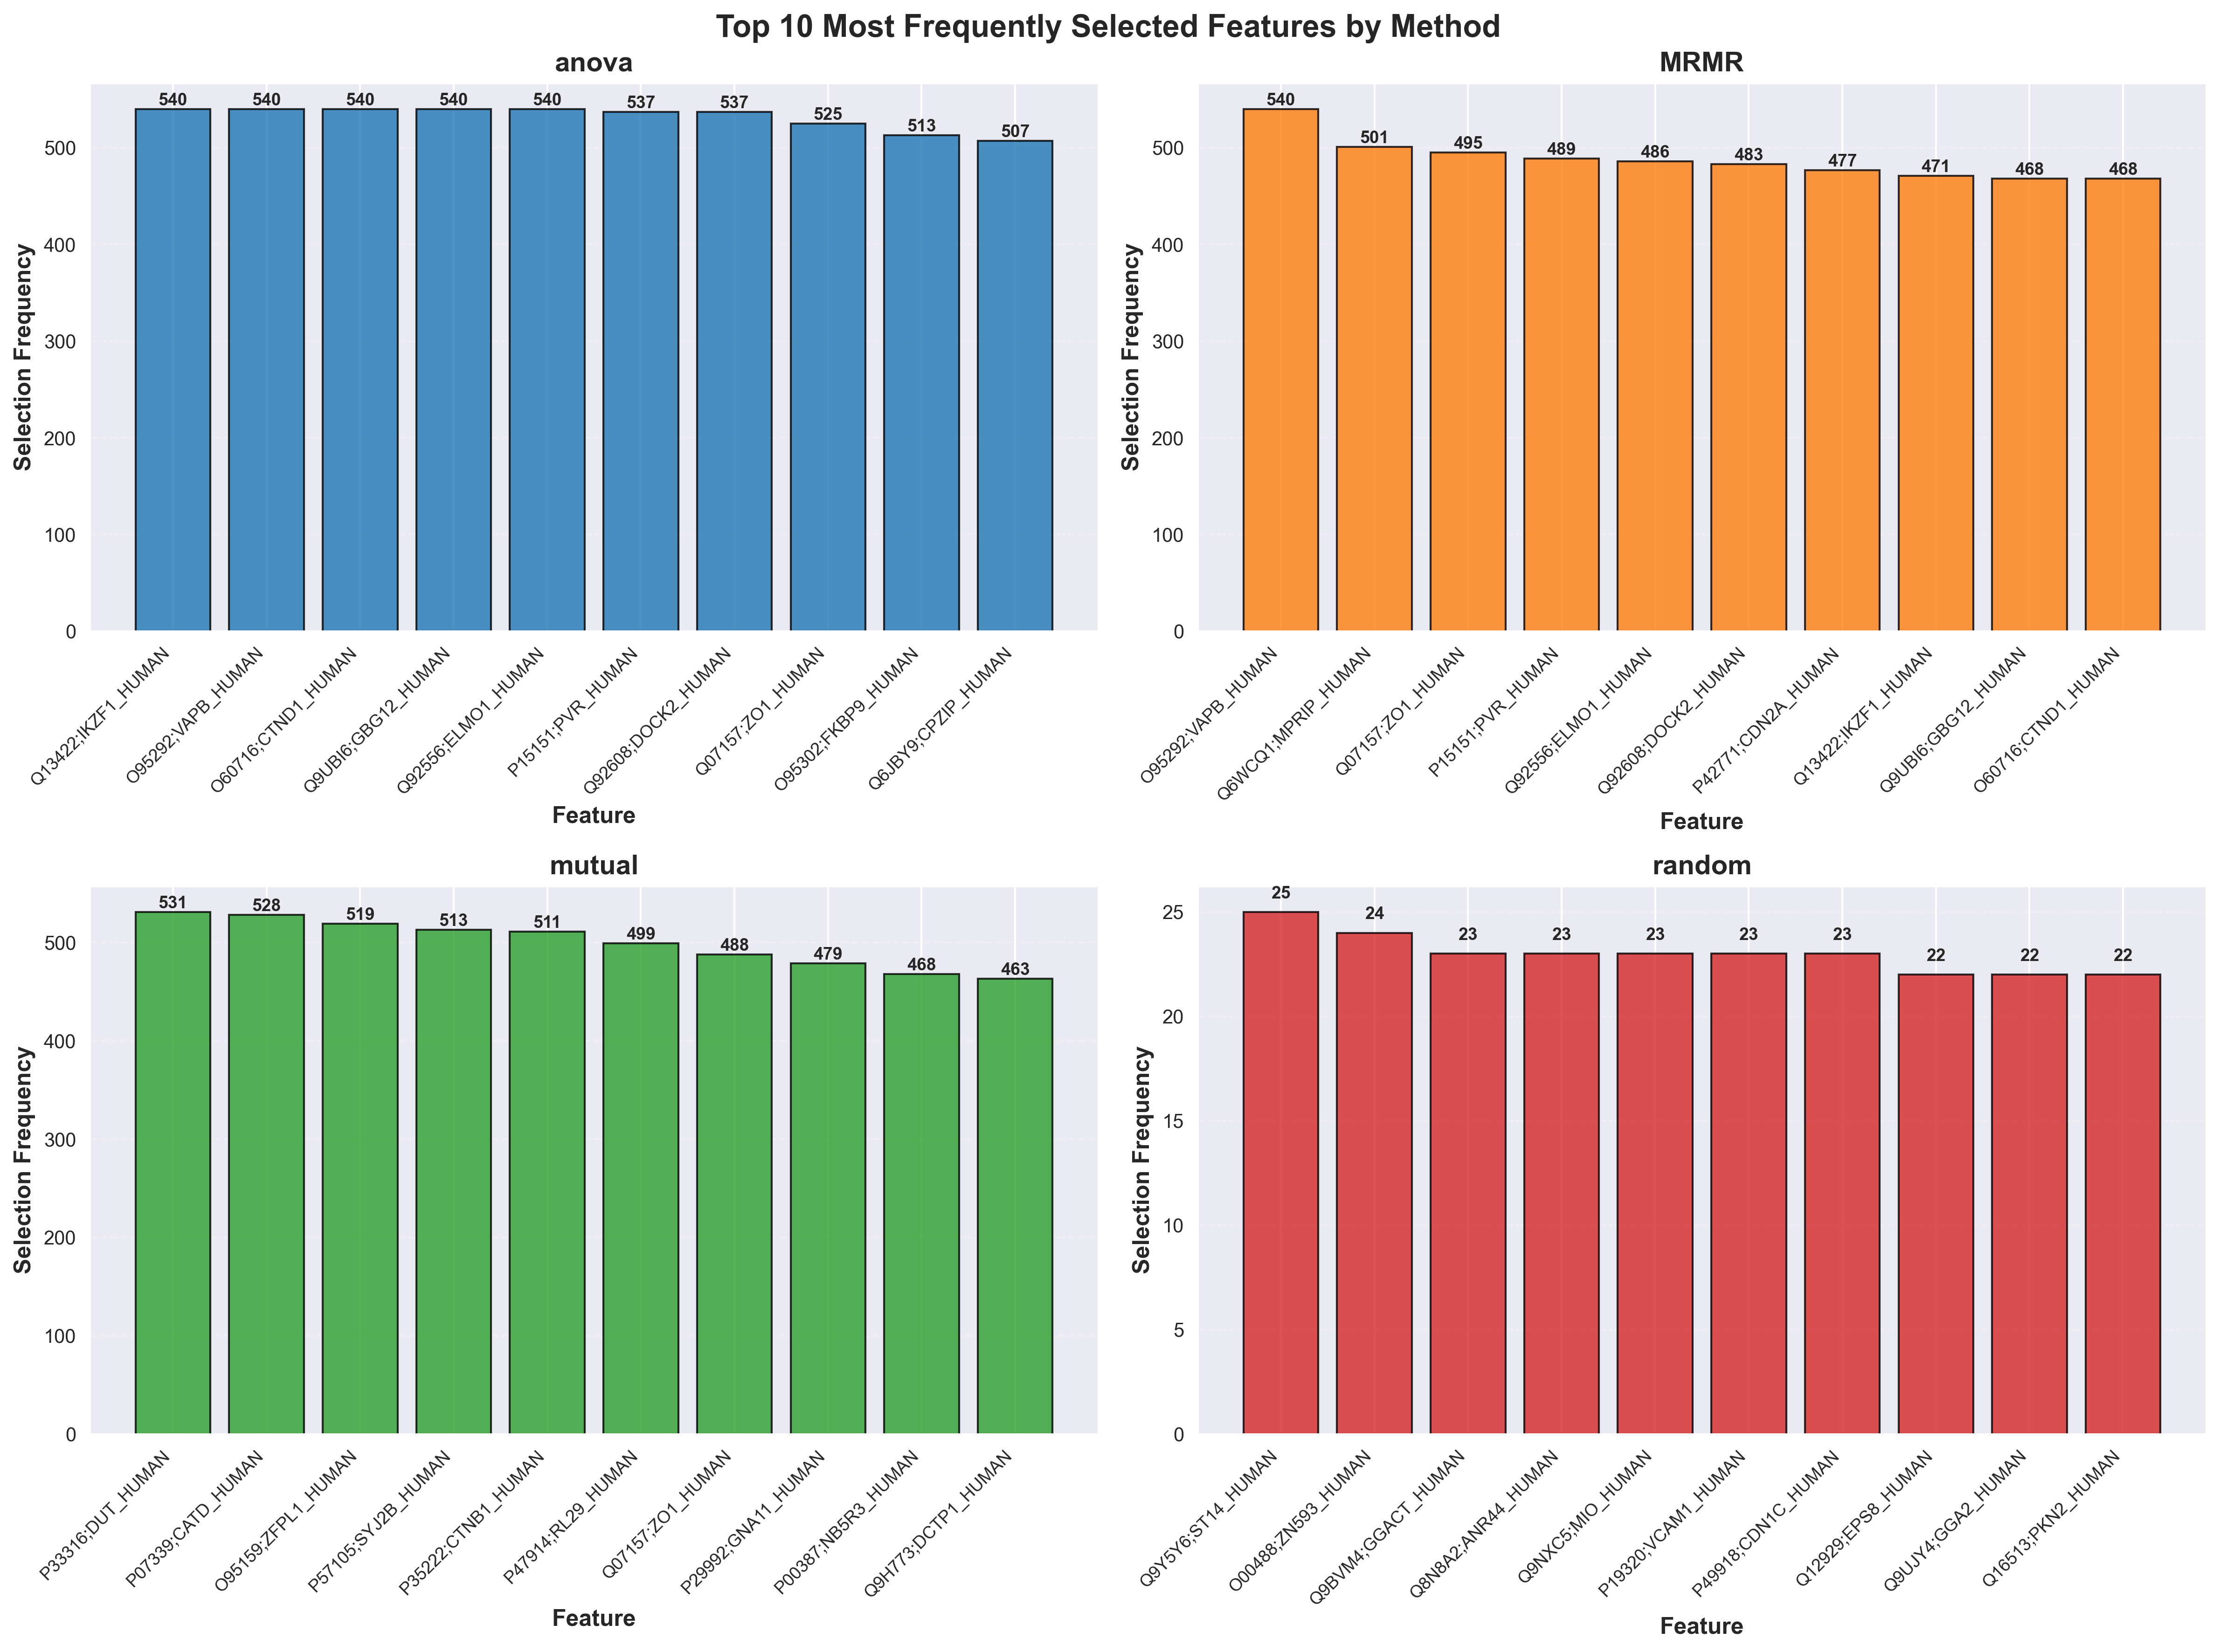

In [71]:
# Create publication-quality faceted bar plots by method
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=300)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.2

# Define publication-quality color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

methods = ['anova', 'mrmr', 'mutual', 'random']
for i, method in enumerate(methods):
    ax = axes[i//2, i%2]
    top_method_features = method_feature_freq[method].head(10)
    
    bars = ax.bar(range(len(top_method_features)), top_method_features.values,
                  color=colors[i], alpha=0.8, edgecolor='black', linewidth=1)
    
    ax.set_title(f'{method_labels.get(method, method)}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('Selection Frequency', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(top_method_features)))
    ax.set_xticklabels(top_method_features.index, rotation=45, ha='right', fontsize=9)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='y', alpha=0.2, linestyle='--')
    
    # Add value labels on bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Top 10 Most Frequently Selected Features by Method', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(f"{file_save_path}top_features_by_method.png", dpi=300, bbox_inches='tight')
plt.show()

### Method-Specific Feature Comparison

In [72]:
# Compare feature selection patterns between methods
save_and_print("Comparing feature selection patterns between methods...", print_report_file, level="section")

# Create sets of top features for each method (top 50 features)
top_features_by_method = {}
for method in methods:
    top_features_by_method[method] = set(method_feature_freq[method].head(50).index)

# Calculate overlaps between methods
overlap_analysis = {}
for i, method1 in enumerate(methods):
    for j, method2 in enumerate(methods):
        if i < j:  # Avoid duplicate comparisons
            overlap = len(top_features_by_method[method1] & top_features_by_method[method2])
            total_union = len(top_features_by_method[method1] | top_features_by_method[method2])
            jaccard_similarity = overlap / total_union if total_union > 0 else 0
            
            overlap_analysis[f"{method1}_{method2}"] = {
                'overlap_count': overlap,
                'jaccard_similarity': jaccard_similarity,
                'method1_features': len(top_features_by_method[method1]),
                'method2_features': len(top_features_by_method[method2])
            }

# Display overlap analysis
save_and_print("Feature Selection Overlap Analysis (Top 50 features per method):", print_report_file, level="subsection")
for comparison, stats in overlap_analysis.items():
    method1, method2 = comparison.split('_')
    save_and_print(f"\n{method_labels.get(method1, method1)} vs {method_labels.get(method2, method2)}:", print_report_file, level="info")
    save_and_print(f"  Overlap: {stats['overlap_count']} features", print_report_file, level="info")
    save_and_print(f"  Jaccard Similarity: {stats['jaccard_similarity']:.3f}", print_report_file, level="info")
    save_and_print(f"  {method_labels.get(method1, method1)} features: {stats['method1_features']}", print_report_file, level="info")
    save_and_print(f"  {method_labels.get(method2, method2)} features: {stats['method2_features']}", print_report_file, level="info")

Comparing feature selection patterns between methods...
Feature Selection Overlap Analysis (Top 50 features per method):

anova vs MRMR:
  Overlap: 32 features
  Jaccard Similarity: 0.471
  anova features: 50
  MRMR features: 50

anova vs mutual:
  Overlap: 19 features
  Jaccard Similarity: 0.235
  anova features: 50
  mutual features: 50

anova vs random:
  Overlap: 0 features
  Jaccard Similarity: 0.000
  anova features: 50
  random features: 50

MRMR vs mutual:
  Overlap: 17 features
  Jaccard Similarity: 0.205
  MRMR features: 50
  mutual features: 50

MRMR vs random:
  Overlap: 0 features
  Jaccard Similarity: 0.000
  MRMR features: 50
  random features: 50

mutual vs random:
  Overlap: 0 features
  Jaccard Similarity: 0.000
  mutual features: 50
  random features: 50


In [73]:
# Identify consensus features selected by multiple methods
consensus_features = {}
for n_methods in range(2, len(methods) + 1):
    # Get features selected by at least n_methods
    feature_method_count = {}
    for feature in feature_frequency.index:
        count = 0
        for method in methods:
            if feature in top_features_by_method[method]:
                count += 1
        feature_method_count[feature] = count
    
    consensus_features[n_methods] = [f for f, c in feature_method_count.items() if c >= n_methods]

save_and_print("Consensus Features Analysis:", print_report_file, level="subsection")
for n_methods, features in consensus_features.items():
    save_and_print(f"\nFeatures selected by at least {n_methods} methods: {len(features)} features", print_report_file, level="info")
    if len(features) > 0:
        save_and_print(f"Top 10: {features[:10]}", print_report_file, level="info")

Consensus Features Analysis:

Features selected by at least 2 methods: 42 features
Top 10: ['Q07157;ZO1_HUMAN', 'P15151;PVR_HUMAN', 'Q13422;IKZF1_HUMAN', 'Q92556;ELMO1_HUMAN', 'Q92608;DOCK2_HUMAN', 'P35222;CTNB1_HUMAN', 'Q9UBI6;GBG12_HUMAN', 'O60716;CTND1_HUMAN', 'P26006;ITA3_HUMAN', 'Q6WCQ1;MPRIP_HUMAN']

Features selected by at least 3 methods: 13 features
Top 10: ['Q07157;ZO1_HUMAN', 'P15151;PVR_HUMAN', 'Q13422;IKZF1_HUMAN', 'Q92556;ELMO1_HUMAN', 'Q92608;DOCK2_HUMAN', 'P35222;CTNB1_HUMAN', 'Q9UBI6;GBG12_HUMAN', 'O60716;CTND1_HUMAN', 'P26006;ITA3_HUMAN', 'Q6WCQ1;MPRIP_HUMAN']

Features selected by at least 4 methods: 0 features


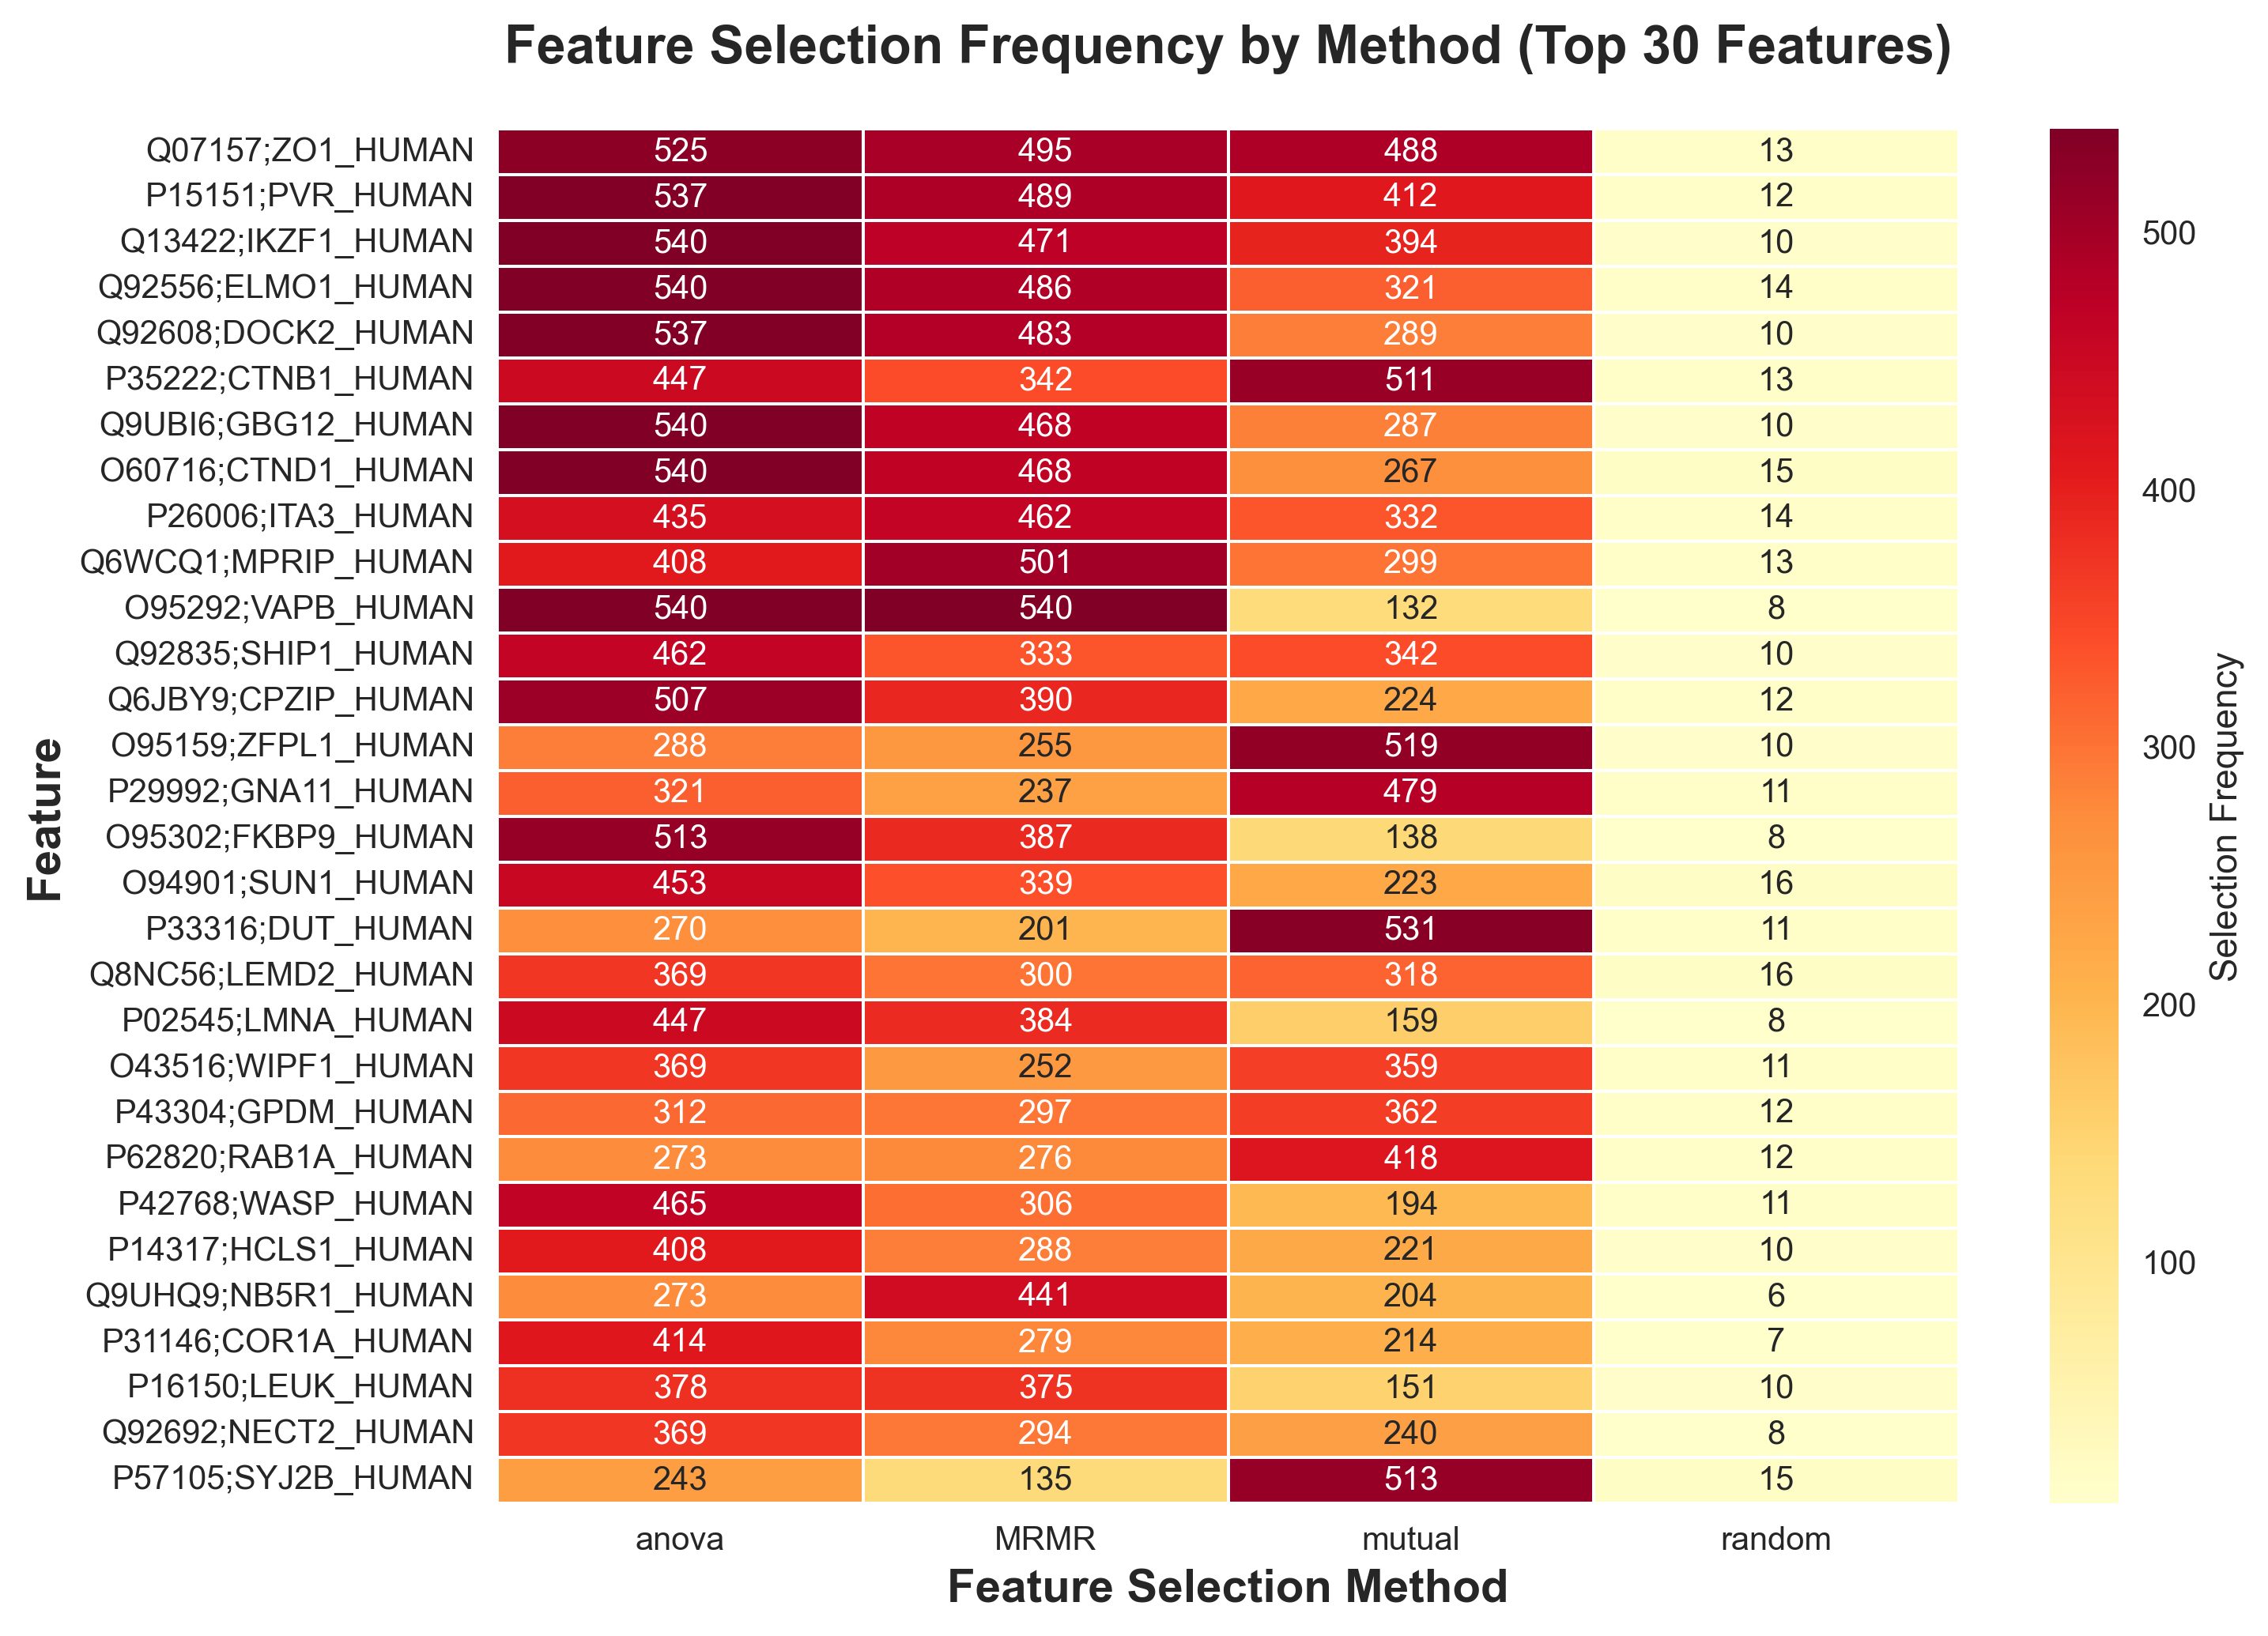

In [74]:
# Create publication-quality heatmap showing feature selection frequency by method
plt.figure(figsize=(10, 7), dpi=300)
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.2

# Get top 30 features overall
top_30_features = feature_frequency.head(30).index

# Create frequency matrix for heatmap
freq_matrix = []
for feature in top_30_features:
    row = []
    for method in methods:
        if feature in method_feature_freq[method]:
            row.append(method_feature_freq[method][feature])
        else:
            row.append(0)
    freq_matrix.append(row)

freq_df = pd.DataFrame(freq_matrix, index=top_30_features, 
                       columns=[method_labels.get(m, m) for m in methods])

# Create heatmap
sns.heatmap(freq_df, annot=True, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Selection Frequency'}, 
            linewidths=0.5, linecolor='white')
plt.title('Feature Selection Frequency by Method (Top 30 Features)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Feature Selection Method', fontsize=14, fontweight='bold')
plt.ylabel('Feature', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{file_save_path}feature_selection_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [75]:
# Summary statistics for feature selection analysis
save_and_print("Feature Selection Analysis Summary:", print_report_file, level="section")
save_and_print(f"Total feature selection events: {len(all_selected_features)}", print_report_file, level="info")
save_and_print(f"Unique features selected: {len(feature_frequency)}", print_report_file, level="info")
save_and_print(f"Average selections per feature: {len(all_selected_features) / len(feature_frequency):.1f}", print_report_file, level="info")

# Method-specific statistics
save_and_print("Method-specific statistics:", print_report_file, level="subsection")
for method in methods:
    method_selections = sum(len(row['selected_features']) for idx, row in df_benchmark[df_benchmark['method'] == method].iterrows() 
                           if isinstance(row['selected_features'], list))
    unique_features = len(method_feature_freq[method])
    avg_selections = method_selections / unique_features if unique_features > 0 else 0
    
    save_and_print(f"\n{method_labels.get(method, method)}:", print_report_file, level="info")
    save_and_print(f"  Total selections: {method_selections}", print_report_file, level="info")
    save_and_print(f"  Unique features: {unique_features}", print_report_file, level="info")
    save_and_print(f"  Average selections per feature: {avg_selections:.1f}", print_report_file, level="info")
    save_and_print(f"  Most frequent feature: {method_feature_freq[method].index[0]} ({method_feature_freq[method].iloc[0]} selections)", print_report_file, level="info")

# Close the print report file
print_report_file.close()
print(f"Print report saved to: {print_report_path}")

Feature Selection Analysis Summary:
Total feature selection events: 291600
Unique features selected: 6661
Average selections per feature: 43.8
Method-specific statistics:

anova:
  Total selections: 72900
  Unique features: 693
  Average selections per feature: 105.2
  Most frequent feature: Q13422;IKZF1_HUMAN (540 selections)

MRMR:
  Total selections: 72900
  Unique features: 817
  Average selections per feature: 89.2
  Most frequent feature: O95292;VAPB_HUMAN (540 selections)

mutual:
  Total selections: 72900
  Unique features: 1183
  Average selections per feature: 61.6
  Most frequent feature: P33316;DUT_HUMAN (531 selections)

random:
  Total selections: 72900
  Unique features: 6661
  Average selections per feature: 10.9
  Most frequent feature: Q9Y5Y6;ST14_HUMAN (25 selections)
Print report saved to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data/results/ThesisResult4-FeatureSelectionBenchmark/feature_selection_print_report_v1.md
